In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
import time

In [2]:
df2 = pd.read_csv(r'DataSets\prices.csv')
info = pd.read_csv(r'DataSets\securities.csv')
df2['Daily Return'] = df2['close'] - df2['open']

In [3]:
df2.shape

(851264, 8)

In [4]:
info.shape

(505, 8)

In [5]:
info = info[info['Ticker symbol'].isin(df2['symbol'])]
info = info[['Ticker symbol', 'GICS Sector', 'GICS Sub Industry']]

In [6]:
df2

,date,symbol,open,close,low,high,volume,Daily Return
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2.409996
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,-5.259995
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,-1.430000
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,1.140000
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,-2.040001
...,...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,-0.110001
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,-0.029999
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,-0.110000
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0,0.720001


In [7]:
df2.isnull().sum()

date            0
symbol          0
open            0
close           0
low             0
high            0
volume          0
Daily Return    0
dtype: int64

In [8]:
df2['symbol'].value_counts()

symbol
AIV     1762
ZION    1762
ZBH     1762
YUM     1762
AMGN    1762
        ... 
KHC      378
HPE      304
CSRA     284
WLTW     251
FTV      126
Name: count, Length: 501, dtype: int64

In [9]:
df2 = df2.merge(info, left_on='symbol', right_on='Ticker symbol')

In [10]:
def add_moving_averages(df, column='Close', sma_window=5, ema_window=10):

    df[f'SMA_{sma_window}'] = df.groupby('symbol')[column].transform(lambda x: x.rolling(window=sma_window).mean())
    df[f'EMA_{ema_window}'] = df.groupby('symbol')[column].transform(lambda x: x.ewm(span=ema_window, adjust=False).mean())

    return df
def add_rsi(df, column='Close', window=14):
    delta = df[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    df[f'RSI_{window}'] = 100 - (100 / (1 + rs))
    return df

def add_macd(df, column='Close', short_window=12, long_window=26, signal_window=9):
    df['MACD_line'] = df[column].ewm(span=short_window, adjust=False).mean() - df[column].ewm(span=long_window, adjust=False).mean()
    df['MACD_signal'] = df['MACD_line'].ewm(span=signal_window, adjust=False).mean()
    return df




In [11]:
add_moving_averages(df2, column='close', sma_window=5, ema_window=10)
add_moving_averages(df2, column='close', sma_window=20, ema_window=50)
add_rsi(df2, column='close', window=14)
#add_macd(df2, column='close', short_window=12, long_window=26, signal_window=9)

,date,symbol,open,close,low,high,volume,Daily Return,Ticker symbol,GICS Sector,GICS Sub Industry,SMA_5,EMA_10,SMA_20,EMA_50,RSI_14
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2.409996,WLTW,Financials,Insurance Brokers,NaN,125.839996,NaN,125.839996,NaN
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,-5.259995,WLTW,Financials,Insurance Brokers,NaN,124.774543,NaN,125.610192,NaN
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,-1.430000,WLTW,Financials,Insurance Brokers,NaN,122.988262,NaN,125.192145,NaN
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,1.140000,WLTW,Financials,Insurance Brokers,NaN,121.830396,NaN,124.855983,NaN
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,-2.040001,WLTW,Financials,Insurance Brokers,118.472000,120.583052,NaN,124.468297,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,-0.110001,ZBH,Health Care,Health Care Equipment,103.043999,103.008135,103.352500,107.030916,58.789265
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,-0.029999,ZION,Financials,Regional Banks,43.380000,43.114522,42.709000,39.090891,51.256525
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,-0.110000,ZTS,Health Care,Pharmaceuticals,53.617999,53.107125,52.075999,51.365061,47.618451
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0,0.720001,AIV,Real Estate,REITs,44.686001,44.375040,43.460000,43.265573,45.700163


In [12]:
df2['Yesterday High'] = df2.groupby('symbol')['high'].shift(1)
df2['Yesterday Low'] = df2.groupby('symbol')['low'].shift(1)
df2['Yesterday return'] = df2.groupby('symbol')['Daily Return'].shift(1)

In [13]:
df2.isnull().sum()
df2.dropna(inplace=True)
df2.shape

(841745, 19)

In [14]:
df2

,date,symbol,open,close,low,high,volume,Daily Return,Ticker symbol,GICS Sector,GICS Sub Industry,SMA_5,EMA_10,SMA_20,EMA_50,RSI_14,Yesterday High,Yesterday Low,Yesterday return
19,2016-02-02 00:00:00,WLTW,113.250000,110.559998,109.750000,113.860001,694800.0,-2.690002,WLTW,Financials,Insurance Brokers,112.564000,112.521503,113.662000,118.851887,39.003949,114.849998,112.900002,0.500000
20,2016-02-03 00:00:00,WLTW,113.379997,114.050003,109.639999,114.639999,896300.0,0.670006,WLTW,Financials,Insurance Brokers,113.232001,112.799412,113.072500,118.663578,52.555378,113.860001,109.750000,-2.690002
21,2016-02-04 00:00:00,WLTW,114.080002,115.709999,114.080002,116.320000,956300.0,1.629997,WLTW,Financials,Insurance Brokers,113.858000,113.328610,112.859000,118.547751,52.816609,114.639999,109.639999,0.670006
22,2016-02-05 00:00:00,WLTW,115.120003,114.019997,109.709999,116.489998,997100.0,-1.100006,WLTW,Financials,Insurance Brokers,113.767999,113.454317,112.812500,118.370192,53.176970,116.320000,114.080002,1.629997
23,2016-02-08 00:00:00,WLTW,113.300003,111.160004,110.459999,113.300003,1200500.0,-2.139999,WLTW,Financials,Insurance Brokers,113.100000,113.037169,112.539500,118.087439,51.614254,116.489998,109.709999,-1.100006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,-0.110001,ZBH,Health Care,Health Care Equipment,103.043999,103.008135,103.352500,107.030916,58.789265,103.739998,102.830002,0.500000
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,-0.029999,ZION,Financials,Regional Banks,43.380000,43.114522,42.709000,39.090891,51.256525,43.639999,42.630001,-0.479999
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,-0.110000,ZTS,Health Care,Pharmaceuticals,53.617999,53.107125,52.075999,51.365061,47.618451,53.779999,53.400002,0.149998
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0,0.720001,AIV,Real Estate,REITs,44.686001,44.375040,43.460000,43.265573,45.700163,44.840000,44.250000,0.340000


In [15]:
X = df2.drop(['date', 'symbol', 'close', 'Daily Return', 'high', 'low'], axis=1)
y = df2['Daily Return']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
#, 'MACD_line', 'MACD_signal'
prep = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['open', 'volume', 'EMA_50', 'SMA_20',  'RSI_14',  'SMA_5',  'EMA_10','Yesterday High', 'Yesterday Low', 'Yesterday return']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['GICS Sector', 'GICS Sub Industry'])
    ])

In [17]:
pipe = Pipeline(
    steps=[
        ('preprocessor', prep),
        ('model', RandomForestRegressor(verbose = 2, n_jobs = -1, random_state = 42))
    ])

In [18]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"--- {name} ---")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"R^2 Score: {r2:.3f}")
    print()


In [19]:
pipe.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 54.1min


building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 443.6min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['open', 'volume', 'EMA_50',
                                                   'SMA_20', 'RSI_14', 'SMA_5',
                                                   'EMA_10', 'Yesterday High',
                                                   'Yesterday Low',
                                                   'Yesterday return']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['GICS Sector',
                                                   'GICS Sub Industry'])])),
                ('model',
                 RandomForestRegressor(n_jobs=-1, random_state=42, verbose=2))])

In [24]:
evaluate_model(pipe, X_test, y_test, "Random Forest Regression with Price Indicators")


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.3s


--- Random Forest Regression with Price Indicators ---
Mean Absolute Error (MAE): 0.676
Mean Squared Error (MSE): 2.055
Root Mean Squared Error (RMSE): 1.434
R^2 Score: 0.052



[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    2.2s finished


--- Random Forest Regression with Price Indicators ---  
Mean Absolute Error (MAE): 0.676
Mean Squared Error (MSE): 2.055
Root Mean Squared Error (RMSE): 1.434
R^2 Score: 0.052

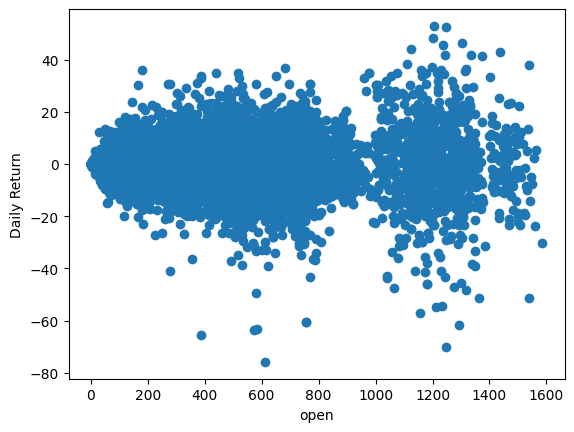

In [21]:
plt.scatter(df2['open'], df2['Daily Return'])
plt.xlabel('open')
plt.ylabel('Daily Return')
plt.show()

In [22]:
# start_time = time.time()
# with tqdm(total=rfr.n_estimators, desc="Fitting model") as pbar:
#     for i in range(rfr.n_estimators):
#         rfr.set_params(n_estimators=i+1)  # Incrementally fitting
#         rfr.fit(X_train, y_train)
#         elapsed_time = time.time() - start_time
#         estimated_total_time = (elapsed_time / (i+1)) * rfr.n_estimators
#         remaining_time = estimated_total_time - elapsed_time
#         pbar.set_postfix({"ETA": f"{remaining_time:.2f} sec"})
#         pbar.update(1)